# MLP model for binary classification

In [19]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix

In [2]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

### Custom pipeline for dat pre-processing

In [3]:
'''
Name: Pre-processing Pipeline
Author: Khanh Nguyen
Description: This file contains the pre-processing pipeline for the dataset that includes label encoding, label processing, and SMOTE.
'''

from imblearn.over_sampling import SMOTE
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = 'Binary', smote = False):
        self.label_encode = label_encode
        self.process_label = process_label
        self.smote = smote
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state', 'attack_cat']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label == 'Binary':
            df.drop('attack_cat', axis=1, inplace=True)
        else:             
            df['attack_cat'], df['label'] = df['label'], df['attack_cat']
            df.drop('attack_cat', axis=1, inplace=True)   

        if self.smote:
            # Separate features and labels
            X = df.drop('label', axis=1)
            y = df['label']

            # Apply SMOTE for oversampling
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X, y)

            # Convert NumPy arrays back to Pandas DataFrames
            X_resampled_df = pd.DataFrame(data=X_resampled, columns=X.columns)
            y_resampled_df = pd.DataFrame(data=y_resampled, columns=['label'])

            # Concatenate the features and label columns into a single DataFrame
            df = pd.concat([X_resampled_df, y_resampled_df], axis=1)   

        return df

In [4]:
# Check null values
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [5]:
pipeline_train = PreProcessPipeline(label_encode=True, process_label='Binary')
pipeline_test = PreProcessPipeline(label_encode=True, process_label='Binary')
train_df = pipeline_train.transform(train_df)
test_df = pipeline_test.transform(test_df)

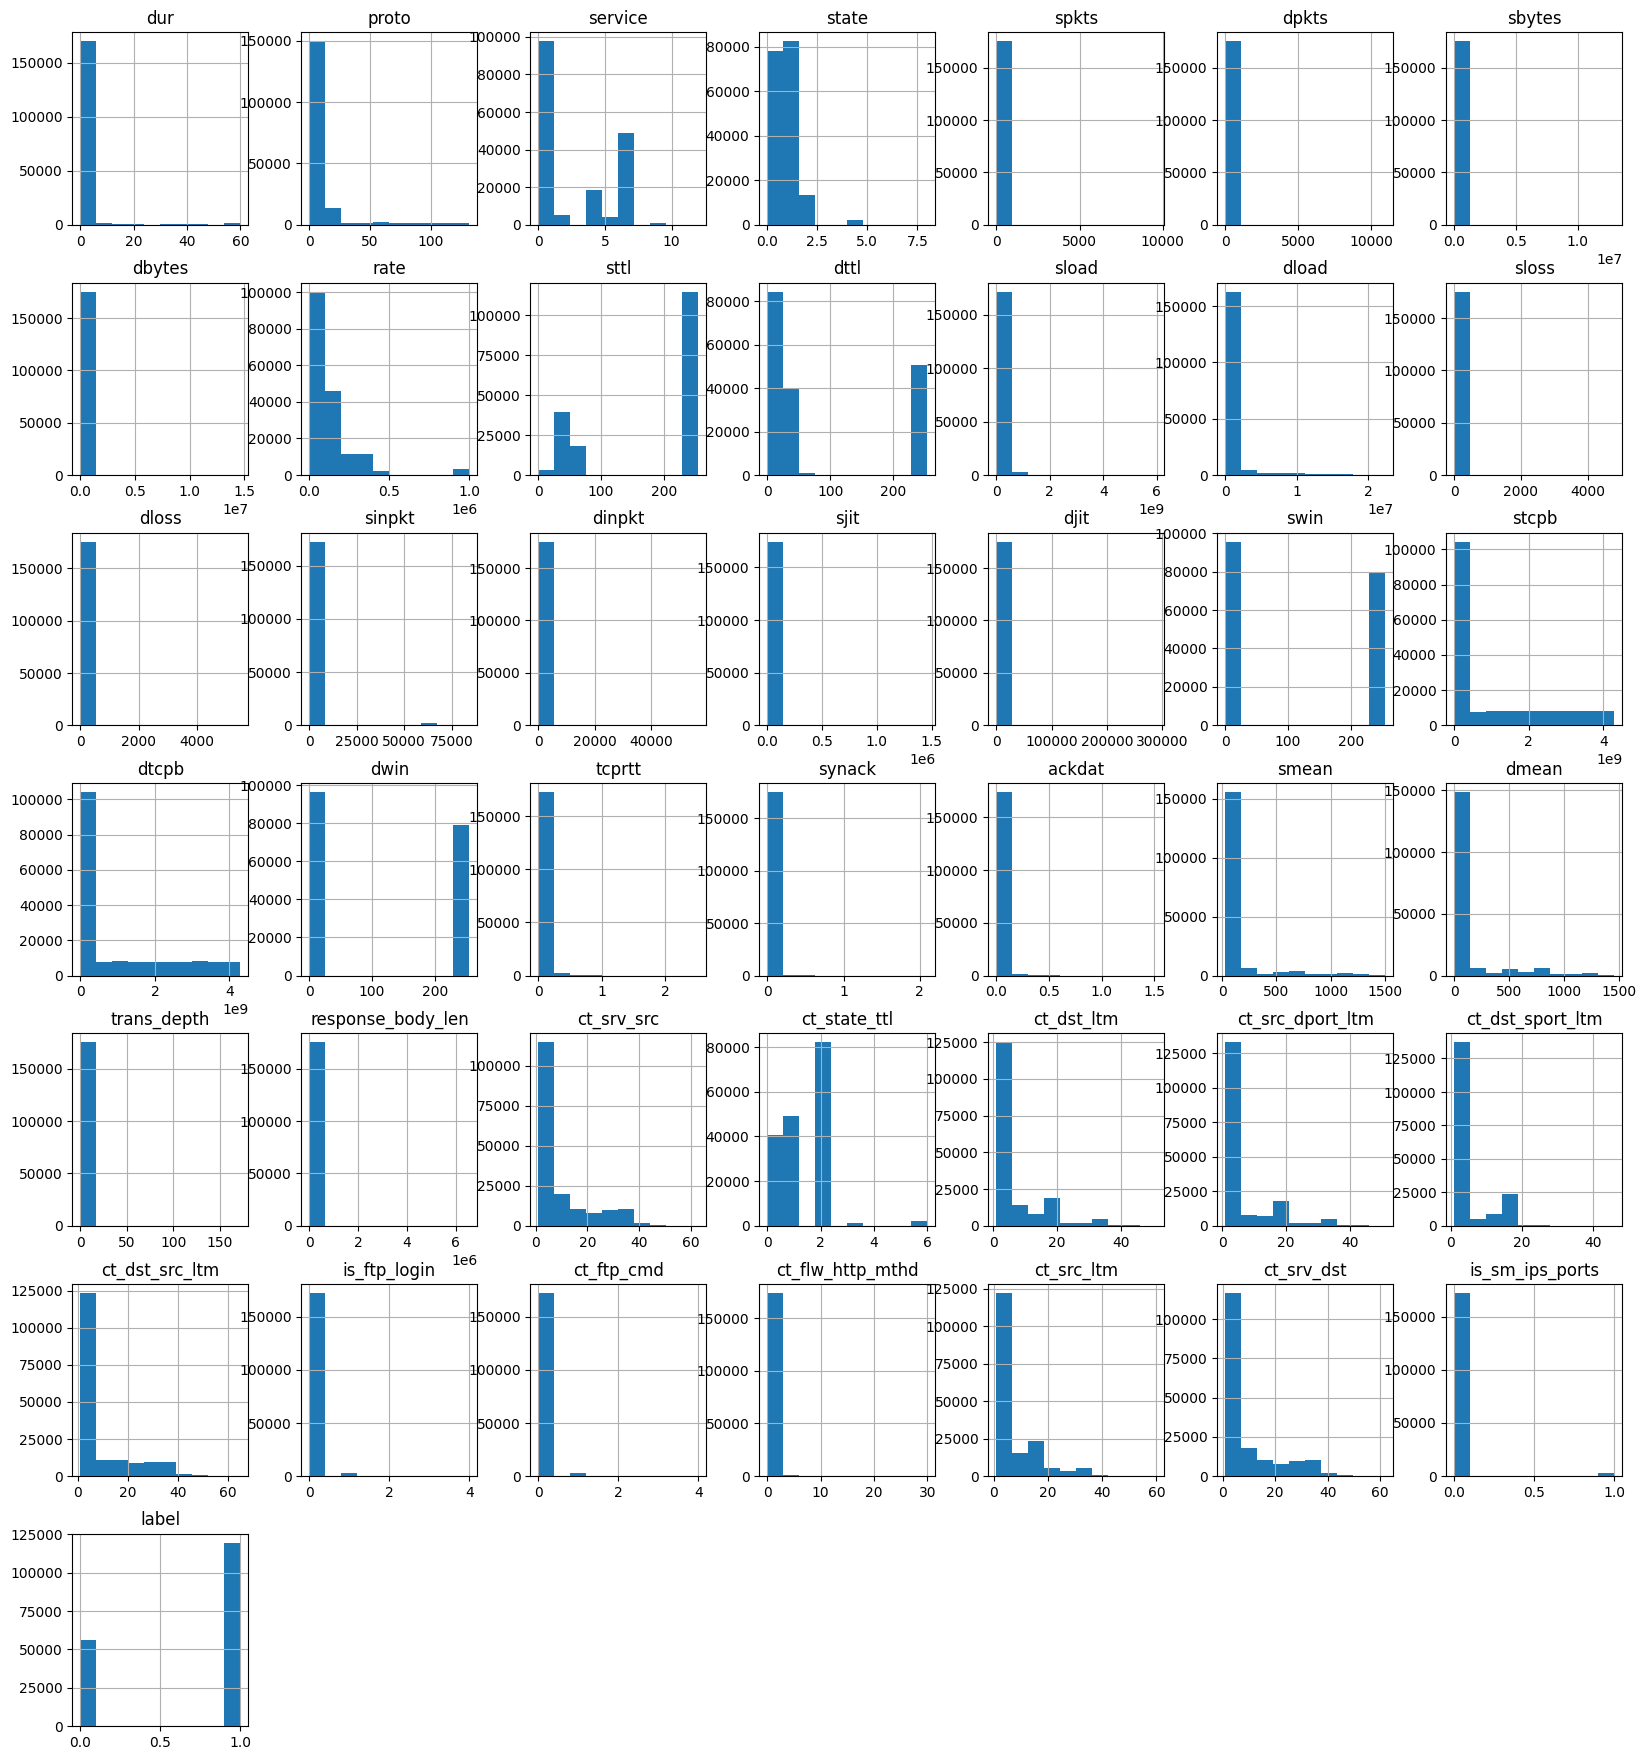

In [6]:
# Plot the histogram of the data
rcParams["figure.figsize"]=(20,22)
test_df.hist()
plt.grid()

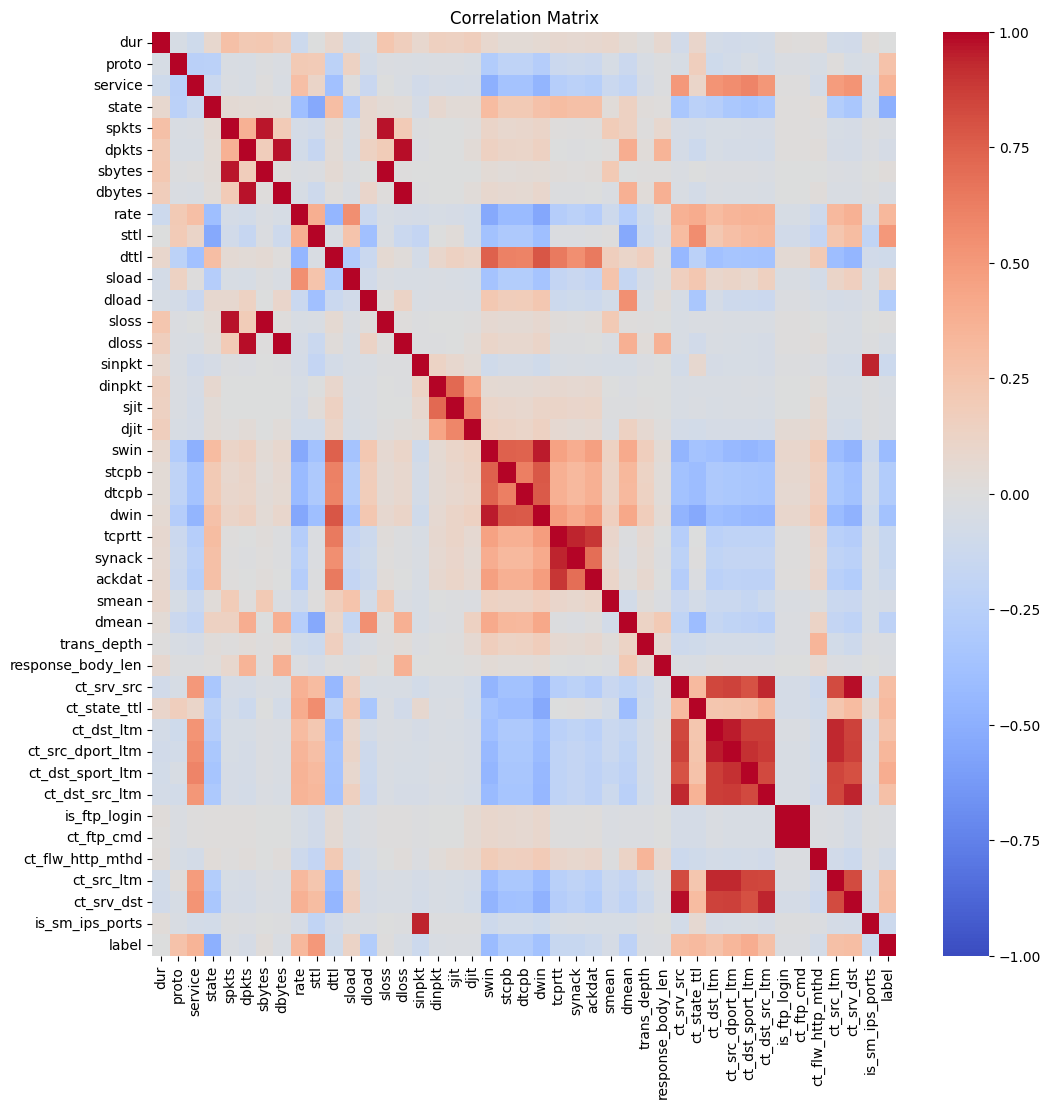

In [7]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = train_df.corr()

# Select the correlation values with 'label', label here means attack_cat
target_corr = corr_matrix['label']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

In [8]:
# Show the feature ranking in corr order 

# Calculate the absolute correlation values with the 'label'
target_corr_abs = corr_matrix['label'].abs()

# Sort the correlation values in descending order
sorted_corr = target_corr_abs.sort_values(ascending=False)

# Print the sorted correlation values and their corresponding attributes
for attribute, correlation in target_corr_abs.items():
    print(f"{attribute}: {correlation:.4f}")

dur: 0.0011
proto: 0.2592
service: 0.3568
state: 0.4993
spkts: 0.0277
dpkts: 0.0615
sbytes: 0.0206
dbytes: 0.0326
rate: 0.3286
sttl: 0.5042
dttl: 0.0986
sload: 0.1245
dload: 0.2805
sloss: 0.0064
dloss: 0.0444
sinpkt: 0.1208
dinpkt: 0.0376
sjit: 0.0274
djit: 0.0271
swin: 0.4145
stcpb: 0.2814
dtcpb: 0.2829
dwin: 0.3693
tcprtt: 0.1488
synack: 0.1499
ackdat: 0.1205
smean: 0.0611
dmean: 0.2115
trans_depth: 0.0258
response_body_len: 0.0164
ct_srv_src: 0.2902
ct_state_ttl: 0.3185
ct_dst_ltm: 0.2580
ct_src_dport_ltm: 0.3415
ct_dst_sport_ltm: 0.3937
ct_dst_src_ltm: 0.2800
is_ftp_login: 0.0162
ct_ftp_cmd: 0.0171
ct_flw_http_mthd: 0.0750
ct_src_ltm: 0.2765
ct_srv_dst: 0.2929
is_sm_ips_ports: 0.1174
label: 1.0000


In [25]:
spark = SparkSession.builder.appName("CSCI316GP2").getOrCreate()

In [26]:
sparktrain_df = spark.createDataFrame(train_df)
sparktest_df = spark.createDataFrame(test_df)

In [27]:
'''
Author: Khanh Nguyen
Name: PySpark Dataframe Pipeline
Description:
    This class is used to create a pipeline for PySpark dataframe, accept 2 boolean parameter: smote & standardize.
    Features 
        (Default)
        - Resample: Resample the dataframe
        - Vectorize: Vectorize the dataframe
        (activate by setting the parameter to True):
        - SMOTE: Oversampling the minority class
        - Standardize: Standardize the dataframe using z-score
'''

from pyspark.sql.functions import col
class SparkDFPipeline:
    def __init__(self, standardize=False):
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):      
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]
            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            train_df = train_df.select('features', 'label')
            test_df = assembler.transform(test_df)
              
        return train_df, test_df

In [28]:
# Pipeline example
pipeline = SparkDFPipeline(standardize=True)
train, test = pipeline.transform(sparktrain_df, sparktest_df)

# ANN model

In [29]:
input_length = len(train.select('features').collect()[0][0])
output_length = train.select('label').distinct().count()

In [30]:
mlp = MultilayerPerceptronClassifier(seed=42, maxIter=100, stepSize=0.001)
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

paramGrid = ParamGridBuilder() \
             .addGrid(mlp.layers, [
                    [input_length, 16, 16, 16, output_length],
                    [input_length, 32, 25, output_length],
             ]) \
             .build()

crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3) 

cv_model = crossval.fit(train)
best_model = cv_model.bestModel
best_params = best_model.extractParamMap()

In [31]:
# Show the best parameters for the model
param_list = [(param.name, value) for param, value in best_params.items()]
shortened_output = "\n".join([f"{param}: {value}" for param, value in param_list])
print(shortened_output)

blockSize: 128
featuresCol: features
labelCol: label
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 42
solver: l-bfgs
stepSize: 0.001
tol: 1e-06
layers: [42, 32, 25, 2]


In [32]:
def evaluate_model(model, val_data, model_name):
    # Make predictions on the validation data
    predictions = model.transform(val_data)

    auc_evaluator = BinaryClassificationEvaluator(labelCol='label')
    auc = auc_evaluator.evaluate(predictions)

    # Calculate Area Under Precision-Recall Curve using BinaryClassificationEvaluator
    pr_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
    area_under_pr = pr_evaluator.evaluate(predictions)

    # Calculate True Positives, True Negatives, False Positives, and False Negatives
    tp = predictions.filter("label = 1 and prediction = 1").count()
    tn = predictions.filter("label = 0 and prediction = 0").count()
    fp = predictions.filter("label = 0 and prediction = 1").count()
    fn = predictions.filter("label = 1 and prediction = 0").count()

    # Calculate metrics using TP, TN, FP, FN
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    # youdens_j = sensitivity + specificity - 1
    # balanced_accuracy = (sensitivity + specificity) / 2

    # Convert Spark DataFrames to Pandas DataFrames for visualization
    y_true_pd = predictions.select('label').toPandas()
    y_pred_pd = predictions.select('prediction', 'probability').toPandas()
    
    # Convert prediction probabilities to binary predictions
    y_pred_binary = [1 if prob[1] >= 0.5 else 0 for prob in y_pred_pd['probability']]
    cm = confusion_matrix(y_true_pd['label'], y_pred_binary)

        # Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], 
                    yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()
    
    # Create a dictionary of model evaluation metrics
    eval_metrics = {
        'AUC': auc,
        'AreaUnderPR': area_under_pr,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Accuracy': accuracy,
        # "Youden's J Index": youdens_j,
        # 'Balanced Accuracy': balanced_accuracy
    }

    return eval_metrics

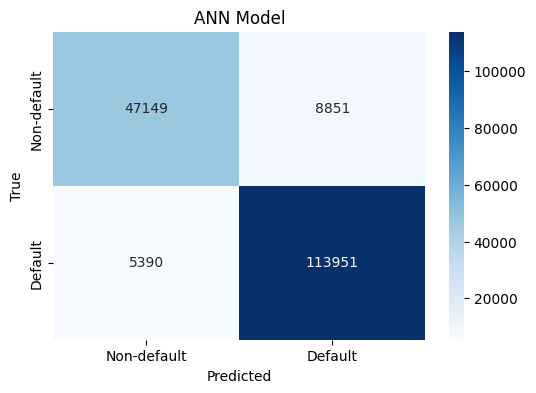

Evaluation Results:
Metric              Default Model       
AUC                 0.9571623843200815  
AreaUnderPR         0.9739627875690899  
Sensitivity         0.9548353038771252  
Specificity         0.8419464285714285  
Precision           0.9279246266347454  
Recall              0.9548353038771252  
F1-Score            0.9411876453170234  
Accuracy            0.9187811179359078  


In [33]:
# Model evaluation
evaluation_results_default = evaluate_model(best_model, test, 'ANN Model')

print("Evaluation Results:")
print(f"{'Metric':<20}{'Default Model':<20}")
print("=" * 60)

for metric in evaluation_results_default.keys():
    default_value = evaluation_results_default[metric]
    print(f"{metric:<20}{default_value:<20}")